## Playment Assignment - Painting Segmentation

Assignment link: https://www.notion.so/playment/Playment-ML-Engineer-Assignment-Segmentation-04bbcb8c4b474603829e531aa5fbe852

Approach: To train a semantic segmentation model using a custom training dataset containing Bob Ross paintings using a MaskRCNN prebuild network provided by Detectron2


In [1]:
# Requirements
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html


     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=d101954ca82b4796adf957e8732eee31981b49967bbcf81955238a039a71da18
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 776 kB/s 
     |████████████████████████████████| 130 kB 7.5 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 145 kB 47.1 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 843 kB 40.8 MB/s 
     |████████████████████████████████

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
# Downloading the Bob Ross painting dataset from Kaggle
# Note: In order to download the dataset from kaggle, please upload the kaggle.json file in the root directory
! mkdir -p ~/.kaggle 
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download residentmario/segmented-bob-ross-images
! unzip -n segmented-bob-ross-images

100% 51.0M/51.1M [00:00<00:00, 71.7MB/s]
100% 51.1M/51.1M [00:00<00:00, 69.0MB/s]
Archive:  segmented-bob-ross-images.zip
  inflating: labels.csv              
  inflating: train/images/painting10.png  
  inflating: train/images/painting101.png  
  inflating: train/images/painting103.png  
  inflating: train/images/painting105.png  
  inflating: train/images/painting109.png  
  inflating: train/images/painting110.png  
  inflating: train/images/painting111.png  
  inflating: train/images/painting112.png  
  inflating: train/images/painting115.png  
  inflating: train/images/painting116.png  
  inflating: train/images/painting117.png  
  inflating: train/images/painting118.png  
  inflating: train/images/painting12.png  
  inflating: train/images/painting120.png  
  inflating: train/images/painting121.png  
  inflating: train/images/painting123.png  
  inflating: train/images/painting124.png  
  inflating: train/images/painting125.png  
  inflating: train/images/painting128.png  
  infl

In [3]:
# Converting the training label images provided in the Bob Ross painting dataset into the Coco annotation format
import coco_convert
import create_annotations
# Get the standard COCO JSON format
coco_format = create_annotations.get_coco_json_format()
mask_path = "train/labels/"
# Create category section
coco_format["categories"] = create_annotations.create_category_annotation(coco_convert.category_ids)
# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = coco_convert.images_annotations_info(mask_path)
with open("annotated_images.json","w") as outfile:
        json.dump(coco_format, outfile)

In [4]:
# Register the custom Bob Ross dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bob_ross_paintings_segmentation", {}, "annotated_images.json", "train/images/")


In [5]:
# getting the metadata from the dataset
painting_metadata = MetadataCatalog.get("bob_ross_paintings_segmentation")
dataset_dicts = DatasetCatalog.get("bob_ross_paintings_segmentation")

WARNING [12/21 15:57:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/21 15:57:50 d2.data.datasets.coco]: Loaded 250 images in COCO format from annotated_images.json


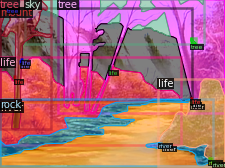

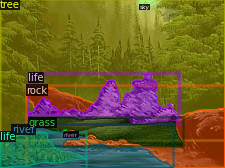

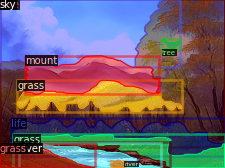

In [6]:
# To verify the data loading is correct, let's visualize the annotations 
# of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=painting_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Training the model using Detectron2's MaskRCNN network
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bob_ross_paintings_segmentation",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2

# initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 50
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Inference & evaluation using the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set the testing threshold for this model
cfg.DATASETS.TEST = ("val_mask",) ## to be added
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


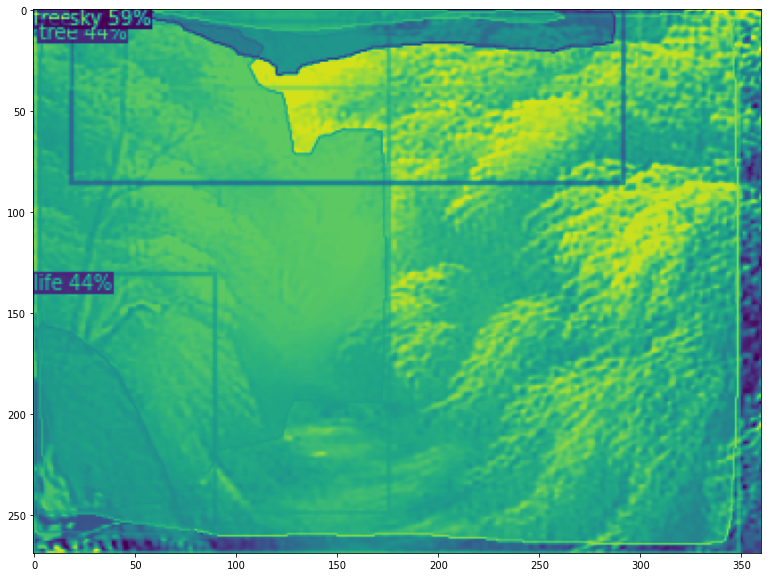

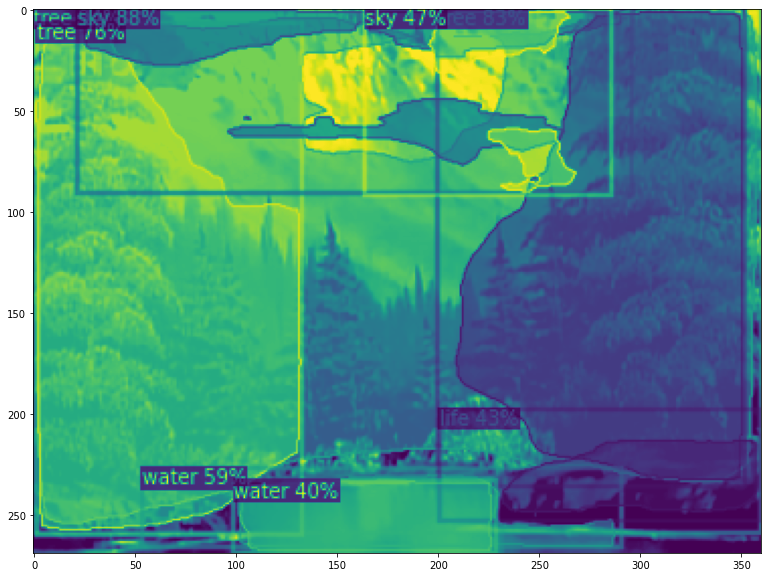

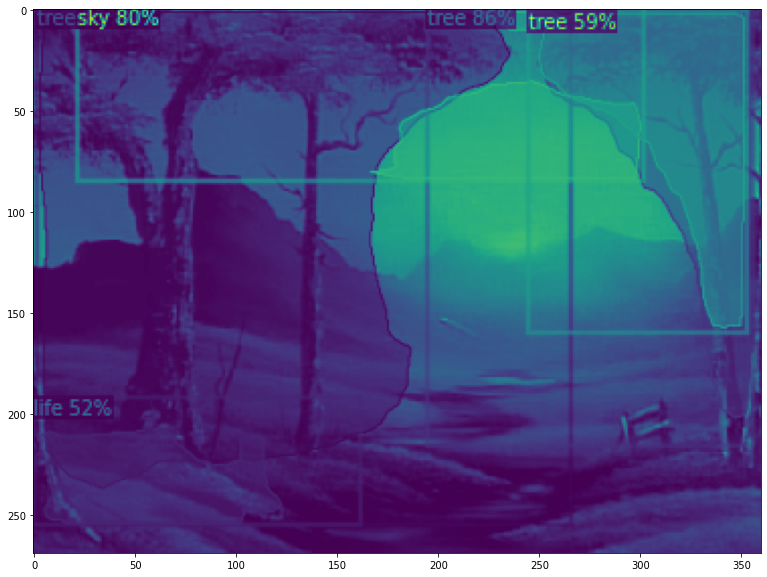

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt

dataset_dicts = dataset_dicts
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=painting_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2GRAY))
    plt.show()

In [ ]:
# Converting the validation set to Coco annotation format
import coco_convert
import create_annotations
# Get the standard COCO JSON format
coco_format = create_annotations.get_coco_json_format()
mask_path = "val/"
# Create category section
coco_format["categories"] = create_annotations.create_category_annotation(coco_convert.category_ids)
# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = coco_convert.images_annotations_info(mask_path)
with open("annotated_images_val.json","w") as outfile:
        json.dump(coco_format, outfile)

In [ ]:
# Register the custom dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("validation", {}, "annotated_images_val.json", "val_mask/")

In [ ]:
# Evaluation criteria
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("validation", ("segm",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "validation")
print(inference_on_dataset(trainer.model, val_loader, evaluator))